 Step 0 out of 10 started
   Decision started
   Conflict resolution started
   Movement started
     Ped 0 moved
     Ped 1 blocked
     Ped 2 moved
     Ped 3 moved
     Ped 4 moved
 Step 1 out of 10 started
   Decision started
   Conflict resolution started
   Movement started
     Ped 0 moved
     Ped 1 moved
     Ped 2 moved
     Ped 3 blocked
     Ped 4 moved
 Step 2 out of 10 started
   Decision started
   Conflict resolution started
   Movement started
     Ped 0 moved
     Ped 1 blocked
     Ped 2 moved
     Ped 3 blocked
     Ped 4 moved
 Step 3 out of 10 started
   Decision started
   Conflict resolution started
   Movement started
     Ped 0 moved
     Ped 1 moved
     Ped 4 blocked
 Step 4 out of 10 started
   Decision started
   Conflict resolution started
   Movement started
     Ped 0 blocker may move
     Ped 1 blocker may move
     Ped 3 blocker may move
     Ped 4 moved
     Ped 0 blocker may move
     Ped 1 blocker may move
     Ped 3 blocker may move
 Step 5 out of

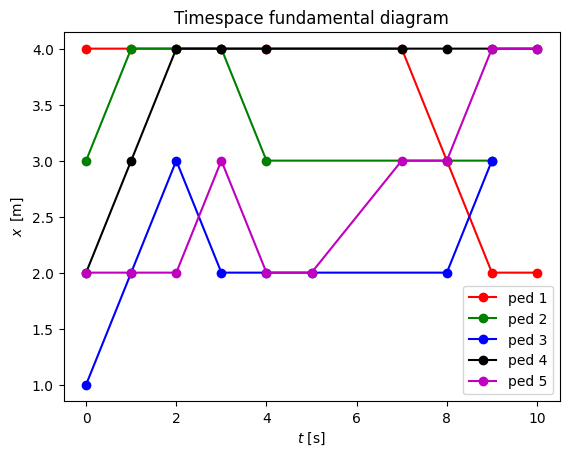

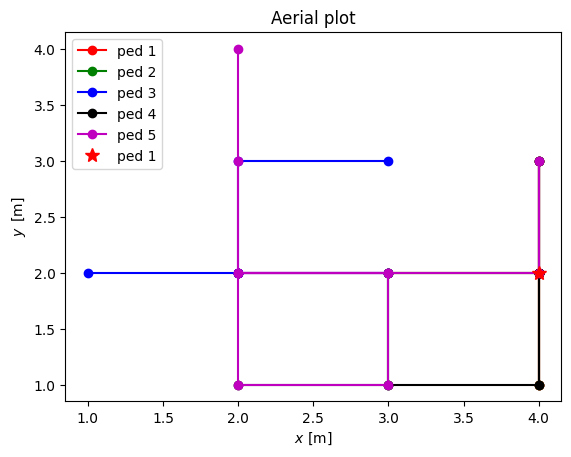

In [3]:
import pandas as pd
import numpy as np
import math as math
import random as rn
from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn' # to supress "A value is trying to be set on a copy of a slice from a DataFrame"

def init_ped_data(t,x,y):
    # initialize ped data container
    # INPUT: vector of init time, init positions

    # init dataframe with the first ped
    ped_data = pd.DataFrame({'ped_id': 0,
                             't': [[t[0]]],                        # to be list of recorded time
                             'x': [[x[0]]],                        # to be list of recorded x position
                             'y': [[y[0]]],                         # to be list of recorded y position
                             'dec_x': np.nan,
                             'dec_y': np.nan
                             }, index = [0])

    # add peds one by one
    rep = range(len(x)-1)
    for i in rep:
        ped_data_n = pd.DataFrame({'ped_id': i+1,
                                't': [[t[i+1]]],
                                'x': [[x[i+1]]],
                                'y': [[y[i+1]]],
                                }, index = [i+1])
        ped_data = pd.concat([ped_data, ped_data_n], ignore_index=True)

    return ped_data


def one_ped_decision(ped_data, ped_idx, distance_grid, const):

    # get profitability
    dist_u = distance_grid[ped_data.x[ped_idx][-1]-1][ped_data.y[ped_idx][-1]]
    dist_d = distance_grid[ped_data.x[ped_idx][-1]+1][ped_data.y[ped_idx][-1]]
    dist_l = distance_grid[ped_data.x[ped_idx][-1]][ped_data.y[ped_idx][-1]-1]
    dist_r = distance_grid[ped_data.x[ped_idx][-1]][ped_data.y[ped_idx][-1]+1]

    # calculate probability
    p_norm = np.exp(-1*dist_u) + np.exp(-1*dist_d) + np.exp(-1*dist_l) + np.exp(-1*dist_r)
    p_u = np.exp(-1*dist_u)/p_norm
    p_d = np.exp(-1*dist_d)/p_norm
    p_l = np.exp(-1*dist_l)/p_norm
#    p_r = np.exp(-1*dist_r)/p_norm

    # distribution function
    cum_p_u = p_u
    cum_p_d = p_d + cum_p_u
    cum_p_l = p_l + cum_p_d
#    cum_p_r = p_r + cum_p_l

    r = rn.random()

    if r < cum_p_u:
        ped_data.dec_x[ped_idx] = ped_data.x[ped_idx][-1] -1
        ped_data.dec_y[ped_idx] = ped_data.y[ped_idx][-1]
    elif r < cum_p_d:
        ped_data.dec_x[ped_idx] = ped_data.x[ped_idx][-1] +1
        ped_data.dec_y[ped_idx] = ped_data.y[ped_idx][-1]
    elif r < cum_p_l:
        ped_data.dec_x[ped_idx] = ped_data.x[ped_idx][-1]
        ped_data.dec_y[ped_idx] = ped_data.y[ped_idx][-1] -1
    else:
        ped_data.dec_x[ped_idx] = ped_data.x[ped_idx][-1]
        ped_data.dec_y[ped_idx] = ped_data.y[ped_idx][-1] +1

    return ped_data


def save_step(ped_data, ped_id, new_x, new_y, new_t):

    ped_data.dec_x[ped_id] = np.nan
    ped_data.dec_y[ped_id] = np.nan
    ped_data.x[ped_id] = ped_data.x[ped_id] + [int(new_x)]
    ped_data.y[ped_id] = ped_data.y[ped_id] + [int(new_y)]
    ped_data.t[ped_id] = ped_data.t[ped_id] + [new_t]

    return ped_data


def resolve_conflicts(ped_data, const, act_t):

    print('   Conflict resolution started')

    rep_x = range(const['grid_size_x'])                                         # For all cells
    for i in rep_x:
        rep_y = range(const['grid_size_y'])
        for j in rep_y:

            ped_conf = []                                                       # Initiate empty "waiting room"

            rep_k = range(const['N_ped']-1)                                     # For all peds
            for k in rep_k:

                if  (ped_data.dec_x[k] == i) & (ped_data.dec_y[k] == j):        # Check whether they want to enther this cell
                    ped_conf = ped_conf + [k]                                   # If so, they are written to waiting list

            if len(ped_conf) > 1:                                               # If waiting room is occupied by more than 2 peds
                r = rn.randint(0,len(ped_conf)-1)                               # Pick one randomly to keep his decision

                rep_id = range(len(ped_conf))
                for p in rep_id:                                                # Others will change they mind and stay at their positions
                    if p != r:
                        ped_data = save_step(ped_data, ped_conf[p], ped_data.x[ped_conf[p]][-1], ped_data.y[ped_conf[p]][-1], act_t)  # Make "stay" step

    return ped_data


def cell_guest(ped_data, x, y):

    ped_id = np.nan

    rep_k = range(const['N_ped']-1)
    for k in rep_k:

        if (ped_data.x[k][-1] == x) & (ped_data.y[k][-1] == y):
            ped_id = ped_data.ped_id[k]

    return ped_id


def execute_all_steps(ped_data, const, act_t):
# Move pedestrians to cell they picked, if it is empty
# Kind of smart logic to resolve the situation when the selected cell is occupied but the blocker ped would move
# I.e. logic here enables the decision algorithm to pick occupied cell

    print('   Movement started')

    peds_to_move = ped_data.ped_id[~ped_data.dec_x.isna()]                  # Initialy, chance to move is defined as True if at least one ped has decision
    chance_to_move = len(peds_to_move) > 0

    while chance_to_move:                                                   # We may need more loops in case of complex blocking situation
                                                                            # The loop will repeated if there was at least one move in previous one
        chance_to_move = False
        peds_to_move = ped_data.ped_id[~ped_data.dec_x.isna()]
        peds_to_move.reset_index(inplace=True, drop=True)

        rep_k = range(len(peds_to_move))                                    # For all peds that may move
        for k in rep_k:

            blocking_ped = cell_guest(ped_data, ped_data.dec_x[peds_to_move[k]], ped_data.dec_y[peds_to_move[k]])   # Who is in his desired cell

            if pd.isna(blocking_ped):                                                     # Noone is blocking
                ped_data = save_step(ped_data, peds_to_move[k], ped_data.dec_x[peds_to_move[k]], ped_data.dec_y[peds_to_move[k]], act_t)  # Make step

                chance_to_move = True
                print('     Ped ' + str(peds_to_move[k]) + ' moved')

            elif pd.isna(ped_data.dec_x[blocking_ped]):                # Blocking ped will not move this time step -> No chance to move this time step
                ped_data = save_step(ped_data, peds_to_move[k], ped_data.dec_x[peds_to_move[k]], ped_data.dec_y[peds_to_move[k]], act_t)   # Make "stay" step

                print('     Ped ' + str(peds_to_move[k]) + ' blocked')

            else:
                print('     Ped ' + str(peds_to_move[k]) + ' blocker may move')

    return ped_data




#============================================#
#              SCRIPT STARTS HERE            #
#============================================#

#======================#
#     PRELIMINARIES    #
#======================#

# Constants - dictionary
const = {'N_ped': 5,                # numer of peds in the system
         'N_step': 10,              # number of steps
         'grid_size_x': 4,          # number of rows
         'grid_size_y': 5,
         'dt': 1,                   # time step length [s]
         'attractor_x': 4,         # x position of attractor [cell]
         'attractor_y': 2           # y position of attractor [cell]
        }

# Init time, positions and velocities
t =  [0,  0, 0, 0, 0]
x =  [4, 3, 1, 2, 2]
y =  [1, 2, 2, 1, 4]

# Init data containers
ped_data = init_ped_data(t,x,y)

distance_grid = [[np.inf,  np.inf, np.inf, np.inf, np.inf, np.inf, np.inf],
                 [np.inf,       4,      3,      4,      5,      6, np.inf],
                 [np.inf,       3,      2,      3,      4,      5, np.inf],
                 [np.inf,       2,      1,      2,      3,      4, np.inf],
                 [np.inf,       1,      0,      1,      2,      3, np.inf],
                 [np.inf,  np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]]


#======================#
#         MODEL        #
#======================#

# Model loop over time
rep = range(const['N_step'])
for i in rep:

    print(' Step ' + str(i) + ' out of ' + str(const['N_step']) + ' started')

    act_t = (i+1)*const['dt']                                       # i+1 is current itteration as i = 0  was defined in init step

    # model desision loop over all peds
    print('   Decision started')
    rep2 = range(const['N_ped'])
    for j in rep2:
        ped_data = one_ped_decision(ped_data, j, distance_grid, const)

    # conflict resolution
    ped_data = resolve_conflicts(ped_data, const, act_t)

    # model movement loop over all peds
    ped_data = execute_all_steps(ped_data, const, act_t)


#======================#
#     POSTPROCESSING   #
#======================#


# Timespace fundamental diagram
plt.figure()
plt.plot(ped_data.t[0], ped_data.x[0], 'r-o', label = 'ped 1')
plt.plot(ped_data.t[1], ped_data.x[1], 'g-o', label = 'ped 2')
plt.plot(ped_data.t[2], ped_data.x[2], 'b-o', label = 'ped 3')
plt.plot(ped_data.t[3], ped_data.x[3], 'k-o', label = 'ped 4')
plt.plot(ped_data.t[4], ped_data.x[4], 'm-o', label = 'ped 5')
plt.title('Timespace fundamental diagram')
plt.xlabel(r'$t \,\,\mathrm{[s]}$')
plt.ylabel(r'$x \,\,\, \mathrm{[m]}$')
#plt.xlim(0, 10)
#plt.ylim(0, 120)
plt.legend()
plt.show()

# Aerial plot
plt.figure()

plt.plot(ped_data.x[0], ped_data.y[0], 'r-o', label = 'ped 1')
plt.plot(ped_data.x[1], ped_data.y[1], 'g-o', label = 'ped 2')
plt.plot(ped_data.x[2], ped_data.y[2], 'b-o', label = 'ped 3')
plt.plot(ped_data.x[3], ped_data.y[3], 'k-o', label = 'ped 4')
plt.plot(ped_data.x[4], ped_data.y[4], 'm-o', label = 'ped 5')
plt.plot(const['attractor_x'], const['attractor_y'], 'r*', label = 'ped 1', markersize=10)
plt.title('Aerial plot')
plt.xlabel(r'$x \,\,\mathrm{[m]}$')
plt.ylabel(r'$y \,\,\, \mathrm{[m]}$')
#plt.xlim(0, 10)
#plt.ylim(0, 120)
plt.legend()
plt.show()